In [2]:
!pip install keras.optimizers

ERROR: Could not find a version that satisfies the requirement keras.optimizers (from versions: none)
ERROR: No matching distribution found for keras.optimizers


In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from datetime import datetime, timedelta
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import sgd
import keras.backend as K
import talib
import traceback
import pickle
from copy import deepcopy
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
    

%matplotlib inline

ImportError: cannot import name 'sgd' from 'keras.optimizers' (C:\Users\ayper\anaconda3\envs\quantra_py\lib\site-packages\keras\optimizers.py)

In [3]:
df = pickle.load(open("PriceData.pick",'rb'))

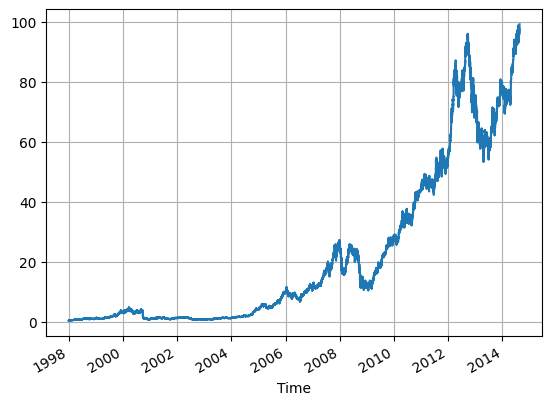

In [4]:
'''
Plot the data.
'''
df['close'].plot()
plt.grid()

In [5]:
def init_net(df,lkbk,START_IDX,max_mem,reward_function):
    """
    This initialises the RL run by instantiating a new Game, 
    creating a new predictive neural network and instantiating
    experience replay.
    Args:
        df: This is the data frame with the market data
        lkbk: This is the lookback period, eg. a value of 10 means 10mins, 10hrs and 10days!
        START_IDX: This is the starting index for the main loop, allow enough for lkbk
        
    Returns:
        env: an instance of Game, our environment
        model: the neural network
        exp_replay: an instance of ExperienceReplay
    """

    bars1h = df['close'].resample('1H',label='right',closed='right').ohlc().dropna()
    bars1d = df['close'].resample('1D',label='right',closed='right').ohlc().dropna()
    env = Game(df, bars1d,bars1h,reward_function, lkbk=lkbk, init_idx=START_IDX)
    hidden_size = len(env.state)*HIDDEN_MULT
    model = Sequential()
    model.add(Dense(len(env.state), input_shape=(len(env.state),), activation=ACTIVATION_FUN))
    model.add(Dense(hidden_size, activation=ACTIVATION_FUN))
    model.add(Dense(NUM_ACTIONS, activation='softmax'))
    model.compile(sgd(lr=LEARNING_RATE), loss=LOSS_FUNCTION)
    
    model2 = Sequential()
    model2.add(Dense(len(env.state), input_shape=(len(env.state),), activation=ACTIVATION_FUN))
    model2.add(Dense(hidden_size, activation=ACTIVATION_FUN))
    model2.add(Dense(NUM_ACTIONS, activation='softmax'))
    model2.compile(sgd(lr=LEARNING_RATE), loss=LOSS_FUNCTION)
    
    exp_replay = ExperienceReplay(max_memory=max_mem)
    
    return env,model,model2,exp_replay  

In [6]:
    """ REWARD FUNCTIONS"""
    
    def get_pnl(entry,curr,pos):
        return (entry - curr)/entry*pos
    
    def reward_func1(entry,curr,pos):
        """positive log categorical"""
        pnl = get_pnl(entry,curr,pos)
        if pnl>=0: 
            return np.ceil(np.log(pnl*100+1))
        else:
            return 0
    
    def reward_func2(entry,curr,pos):
        '''pure pnl'''
        return get_pnl(entry,curr,pos)
    
    def reward_func3(entry,curr,pos):
        '''positive pnl, zero otherwise'''
        pnl = get_pnl(entry,curr,pos)
        if pnl>=0: 
            return pnl
        else:
            return 0
    
    def reward_func4(entry,curr,pos):
        '''Sign of pnl'''
        return np.sign(get_pnl(entry,curr,pos))
    
    def reward_func5(entry,curr,pos):
        '''1 for win, 0 for loss'''
        pnl = get_pnl(entry,curr,pos)
        if pnl>=0: 
            return 1
        else:
            return 0
    
    def reward_func6(entry,curr,pos):
        '''pure pnl'''
        return np.exp(get_pnl(entry,curr,pos))

In [7]:
class Game(object):

    def __init__(self, df,bars1d,bars1h,reward_function, lkbk=20, init_idx=None):
        self.df = df
        self.lkbk = lkbk
        self.trade_len = 0
        self.stop_pnl = None
        self.bars1d =  bars1d
        self.bars1h =  bars1h
        self.is_over = False
        self.reward = 0
        self.pnl_sum = 0
        self.init_idx = init_idx
        self.reward_function = reward_function
        self.reset()
        
    def _update_state(self, action):
        
        '''Here we update our state.
        The state consists of the current parameters of the system,
        similar to the current frame of a gaming screen. It includes
        current time, price, position and reward.
        We the add secondary features such as technical indicators in _assemble state.
        Args:
            action: The action suggested by the neural network based on past experience
        '''
        self.curr_idx += 1
        self.curr_time = self.df.index[self.curr_idx]
        self.curr_price = self.df['close'][self.curr_idx]
        self.curr_low = self.df['low'][self.curr_idx]
        self.pnl = (-self.entry + self.curr_price)*self.position/self.entry
        self._assemble_state()
        tm_lst = list(map(float,str(self.curr_time.time()).split(':')[:2]))
        self._time_of_day = (tm_lst[0]*60 + tm_lst[1])/(24*60) 
        self._day_of_week  = self.curr_time.weekday()/6
        
        '''This is where we define our policy and update our position'''
        if action == 0:  
            pass
        
        elif action == 2:
            """---Enter a long or exit a short position---"""
            if self.position == -1:
                self.is_over = True
                self._get_reward()
                self.trade_len = self.curr_idx - self.start_idx
   
            elif self.position == 0:
                self.position = 1
                self.entry = self.curr_price
                self.start_idx = self.curr_idx
            else: 
                pass
            
        elif action == 1:
            """---Enter a short or exit a long position---"""
            if self.position == 1:
                self.is_over = True
                self._get_reward()
                self.trade_len = self.curr_idx - self.start_idx

            elif self.position == 0:
                self.position = -1
                self.entry = self.curr_price
                self.start_idx = self.curr_idx
            else:
                pass
        
    
    def _assemble_state(self):
        '''Here we can add secondary features such as indicators and times to our current state.
        First, we create candlesticks for different bar sizes of 5mins, 1hr and 1d.
        We then add some state variables such as time of day, day of week and position.
        Next several indicators are added and subsequently z-scored.
        '''
        
        """---Adding State Variables---"""
        self.state = np.array([])
        
        """---Adding Candlesticks---"""
        self._get_last_N_timebars()
        bars = [self.last5m,self.last1h,self.last1d]
        state_bars = []
        candles = {j:{k:np.array([]) for k in ['open','high','low','close']} for j in range(len(bars))}
        for j,bar in enumerate(bars):
            for col in ['open','high','low','close']:
                candles[j][col] = np.asarray(bar[col])
                state_bars += (list(np.asarray(bar[col]))[-10:])
                
        self.state = np.append(self.state,state_bars)

        """---Adding Techincal Indicators---"""
        for c in candles:
            try:
                sma1 = talib.SMA(candles[c]['close'],self.lkbk-1)[-1]
                sma2 = talib.SMA(candles[c]['close'],self.lkbk-8)[-1]
                self.state = np.append(self.state,(sma1-sma2)/sma2)
                self.state = np.append(self.state,talib.RSI(candles[c]['close'],self.lkbk-1)[-1])
                self.state = np.append(self.state,talib.MOM(candles[c]['close'],self.lkbk-1)[-1])
                self.state = np.append(self.state,talib.BOP(candles[c]['open'],
                                               candles[c]['high'],
                                               candles[c]['low'],
                                               candles[c]['close'])[-1])

                self.state = np.append(self.state,talib.AROONOSC(candles[c]['high'],
                                               candles[c]['low'],
                                               self.lkbk-3)[-1])
            except: print(traceback.format_exc())
                
        """---Normalizing Candlesticks---"""
        self.state = (np.array(self.state)-np.mean(self.state,axis=0))/np.std(self.state,axis=0)
        
        self.state = np.append(self.state,self.position)
        self.state = np.append(self.state,self._time_of_day)
        self.state = np.append(self.state,self._day_of_week)
        #print(list(map(len,[self.last5m,self.last1h,self.last1d])))
        
    def _get_last_N_timebars(self):
        '''This function gets the timebars for the 5m, 1hr and 1d resolution based
        on the lookback we've specified.
        '''
        wdw5m = 9
        wdw1h = np.ceil(self.lkbk*15/24.)
        wdw1d = np.ceil(self.lkbk*17)
        
        """---creating the candlesticks based on windows---"""
        self.last5m = self.df[self.curr_time-timedelta(wdw5m):self.curr_time].iloc[-self.lkbk:]
        self.last1h = self.bars1h[self.curr_time-timedelta(wdw1h):self.curr_time].iloc[-self.lkbk:]
        self.last1d = self.bars1d[self.curr_time-timedelta(wdw1d):self.curr_time].iloc[-self.lkbk:]
        
    def _get_reward(self):
        """Here we calculate the reward when the game is finished.
        Reward function design is very difficult and can significantly
        impact the performance of our algo.
        In this case we use a simple pnl reward but it is conceivable to use
        other metrics such as Sharpe ratio, average return, etc.
        """
        if self.is_over:
            self.reward = self.reward_function(self.entry,self.curr_price,self.position)


            
    def observe(self):
        """This function returns the state of the system.
        Returns:
            self.state: the state including indicators, position and times.
        """
        return np.array([self.state])

    def act(self, action):
        """This function updates the state based on an action
        that was calculated by the NN.
        This is the point where the game interacts with the trading
        algo.
        """
        self._update_state(action)
        reward = self.reward
        game_over = self.is_over
        return self.observe(), reward, game_over

    def reset(self):
        """Resetting the system for each new trading game.
        Here, we also resample the bars for 1h and 1d.
        Ideally, we should do this on every update but this will take very long.
        """
        self.pnl = 0
        self.entry = 0
        self._time_of_day = 0
        self._day_of_week = 0
        self.curr_idx = self.init_idx         
        self.t_in_secs = (self.df.index[-1]-self.df.index[0]).total_seconds()
        self.start_idx = self.curr_idx
        self.curr_time = self.df.index[self.curr_idx]
        self._get_last_N_timebars()
        self.state = []
        self.position = 0
        self._update_state(0)

In [8]:
class ExperienceReplay(object):
    '''This class calculates the Q-Table.
    It gathers memory from previous experience and 
    creates a Q-Table with states and rewards for each
    action using the NN. At the end of the game the reward
    is calculated from the reward function. 
    The weights in the NN are constantly updated with each new
    batch of experience. 
    This is the heart of the RL algorithm.
    Args:
        state_tp1: state at time t+1
        state_t: state at time t
        action_t: int {0..2} hold, sell, buy taken at state_t 
        Q_sa: float, reward for state_tp1
        reward_t: reward for state_t
        self.memory: list of state_t, action_t and reward_t at time t as well as state_tp1
        targets: array(float) Nx2, weight of each action 
        inputs: an array with scrambled states at different times
        targets: Nx3 array of weights for each action for scrambled input states
    '''
    def __init__(self, max_memory=1000, discount=DISCOUNT_RATE):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, game_over):
        '''Add states to time t and t+1 as well as  to memory'''
        self.memory.append([states, game_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def process(self, modelQ, modelR, batch_size=10):
        len_memory = len(self.memory)
        num_actions = modelQ.output_shape[-1]
        env_dim = self.memory[0][0][0].shape[1]
        
        """---Initialise input and target arrays---"""
        inputs = np.zeros((min(len_memory, batch_size), env_dim))
        targets = np.zeros((inputs.shape[0], num_actions))
        
        """Step randomly through different places in the memory
        and scramble them into a new input array (inputs) with the
        length of the pre-defined batch size"""
        
        for i, idx in enumerate(np.random.randint(0, len_memory, size=inputs.shape[0])):
            
        #for i, idx in enumerate(np.arange(-inputs.shape[0],0)):    
            """Obtain the parameters for Bellman from memory,
            S.A.R.S: state, action, reward, new state."""
            state_t, action_t, reward_t, state_tp1 = self.memory[idx][0]
            game_over = self.memory[idx][1]
            inputs[i] = state_t    
            
            """---Calculate the targets for the state at time t---"""
            targets[i] = modelR.predict(state_t)[0]
            
            """---Calculate the reward at time t+1 for action at time t---"""
            Q_sa = np.max(modelQ.predict(state_tp1)[0])
           
            if game_over:
                """---When game is over we have a definite reward---"""
                targets[i, action_t] = reward_t
            else:
                """
                ---Update the part of the target for which action_t occured to new value---
                Q_new(s,a) = reward_t + gamma * max_a' Q(s', a')
                """
                targets[i, action_t] = reward_t + self.discount * Q_sa
        
      
        return inputs, targets

NameError: name 'DISCOUNT_RATE' is not defined

In [ ]:
def run(df,preload=False,update_qr=True,pnl_file=PNL_FILE,reward_function=reward_func2):
    pnls = []
    pnl_dates = []
    e = 0

    """---Initialise a NN and a set up initial game parameters---"""
    env,q_network,r_network,exp_replay = init_net(df,LKBK,START_IDX,MAX_MEM,reward_function)
    
    """---Preloading the model weights---"""
    if preload:
        q_network.load_weights(WEIGHTS_FILE)
        r_network.load_weights(WEIGHTS_FILE)
        
    r_network.set_weights(q_network.get_weights())
        
    bars1h = df['close'].resample('1H',label='right',closed='right').ohlc().dropna()
    bars1d = df['close'].resample('1D',label='right',closed='right').ohlc().dropna()
    

    """---Loop that steps through one trade (game) at a time---"""
    while True:
        
        """---Stop the algo when end is near to avoid exception---"""
        if env.curr_idx >= len(df)-1000:#len(df)+60000:
            break
        
        e += 1
        
        """---Initialise a new game---"""
        env = Game(df, bars1d,bars1h,reward_function,lkbk=LKBK, init_idx=env.curr_idx)
        
        """---Calculate epsilon for exploration vs exploitation random action generator---"""
        epsilon = EPSILON**(np.log10(e))+EPS_MIN
         

        
        game_over = False
        state_tp1 = env.observe()
        cnt = 0
        
        """---Walk through time steps starting from the end of the last game---"""
        while not game_over:
            cnt += 1
            state_t = state_tp1
            
            #"""---Generate a random action---"""
            if np.random.rand() <= epsilon:
                action = np.random.randint(0, 3, size=1)[0]
            
            #"""---Action for opening a trade---"""
            else:
                q = q_network.predict(state_t)
                action = np.argmax(q[0])

            #"""---Updating the Game---"""
            state_tp1, reward, game_over = env.act(action)
            
            #"""---Adding state to memory---"""
            #print(env.curr_time,len(state_t[0]),len(state_tp1[0]))
            exp_replay.remember([state_t, action, reward, state_tp1], game_over)

            #"""---Creating a new Q-Table---"""
            inputs, targets = exp_replay.process(q_network, r_network, batch_size=BATCH_SIZE)
            env.pnl_sum = sum(pnls)

            #"""---Update the NN model with a new Q-Table"""
            q_network.train_on_batch(inputs, targets)
            if game_over and update_qr:
            #if env.curr_idx<3000 or not env.curr_idx%1000:
               r_network.set_weights(q_network.get_weights())
                
            #"""---This is a stop but it ensures that the cycle runs until the end---"""
#             if env.pnl<=-0.1:
#                 if not env.stop_pnl: 
#                     print('STOP LOSS; len: %s'%(env.curr_idx-env.start_idx))
                                                                    
#                 env.stop_pnl = -0.1
                
                
        
        if env.stop_pnl:
            pnls.append(env.stop_pnl)
        else:
            pnls.append(env.pnl)
        pnl_dates.append(env.curr_time)
        pickle.dump([pnl_dates,pnls],open(pnl_file,'wb'))
        
        print("Trade {:03d} | pos {} | len {} | pnl {:,.2f}% | eps {:,.4f} | {} | {}".format(e,  
                                                                              env.position, 
                                                                              env.trade_len,
                                                                              sum(pnls)*100,
                                                                              epsilon,
                                                                              env.curr_time,
                                                                              env.curr_idx))


        
        if not e%10:
            print('----saving weights-----')
            r_network.save_weights(WEIGHTS_FILE, overwrite=True)

    print('***FINISHED***')

In [ ]:
"""CONFIG"""
LEARNING_RATE = 0.001
LOSS_FUNCTION = 'mse'
ACTIVATION_FUN = 'relu'
NUM_ACTIONS = 3
HIDDEN_MULT = 2
DISCOUNT_RATE = 0.99
LKBK = 30
BATCH_SIZE = 1
MAX_MEM = 600
EPSILON = 0.01
EPS_MIN = 0.001
START_IDX = 5000
WEIGHTS_FILE = "indicator_model.h5"
PNL_FILE = 'pnls.pick'
RF = reward_func6

In [ ]:
# for i in range(10):
#     print('==================TRAIN RUN %s=============='%i)
#     dfn = deepcopy(dft)
#     run(dfn, preload=False,update_qr=True,pnl_file='pnls%s.pick'%i)
run(df, 
       preload=False,
       update_qr=True,
       reward_function=RF)